# Overview
###     In some situations, we only have limited amout of dataset, but we still want to train a very robust machine learning model ourselves. So,  it's a very good way to use some pre-trained models created by professionals before. These models have good structures and contain a large amout of  pre-trained parameters which can deal with problem that you only have very small dataset. And you can easily load these models from 'Keras'. VGG16 is one of the good examples which has been widely used.

# Import all packeages 

In [1]:
# *****note*****
# make sure you are using 'Keras' version is 2.1.6, otherwise you may not able to load your model!!!
# so after installing tensorflow,install your Keras using 'pip install keras==2.1.6' in command prompt, 
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential,load_model
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Define files path for 'train', 'test', 'valid' dataset


In [4]:
train_path = 'data/train'
test_path = 'data/test'
valid_path = 'data/valid'

# Load all 'train', 'test', 'valid' dataset

In [9]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes=['0','1','2','3'],batch_size=8) 
# target_size: the size of pictures | classes: the file name of your different classes 
test_batches = ImageDataGenerator().flow_from_directory(test_path,target_size= (224,224),classes=['0','1','2','3'],batch_size=5)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),classes=['0','1','2','3'],batch_size=10)

Found 320 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


# Show some sample pictures

### Define 'plots' function to show pictures

In [10]:
def plots(ims,figsize=(12,6),rows=1,interp=False,titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1]!=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 ==0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i],fontsize=16)
        plt.imshow(ims[i],interpolation=None if interp else 'none')

In [11]:
imgs, labels =next(train_batches) # read the image and corresponding labels which indicate the class

C:\Anaconda3\lib\site-packages\matplotlib\text.py:1190: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


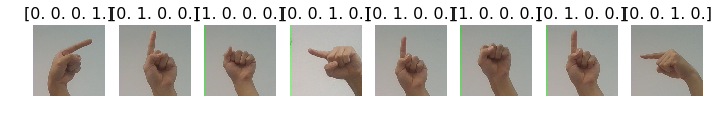

In [12]:
plots(imgs,titles=labels) # the labels are in 'one-hot' format

# Load VGG16 pretrained model from Keras

In [13]:
vgg16_model = keras.applications.vgg16.VGG16(include_top=True,weights='imagenet')
# automatically download vgg16 model from the website below, which is about 500 MB,
# which may takes 15 mins
# once downloaded, you don't need to download again

### Show VGG16 model structure

In [14]:
vgg16_model.summary() # contain total 16 layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
type(vgg16_model) # the type of the model

keras.engine.training.Model

### Change model type from 'model' to 'Sequential'

In [16]:
model = Sequential() #define your own model
for layer in vgg16_model.layers[:-1]: # elimilate the last 'Dense' layer because we don't want 1000 classes, only 4 classes
    model.add(layer)

In [18]:
model.summary() # to see the last layer is gone

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [19]:
for layer in model.layers:
   layer.trainable = False

### Add 'softmax' layer

In [20]:
model.add(Dense(4,activation='softmax')) # total 4 classes.

In [21]:
model.summary() # to see we've changed the last layer to only output 4 classes

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Start to train our customized model

In [22]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy']) # define loss function and loss optimizer

In [16]:
model.fit_generator(train_batches, steps_per_epoch=8,validation_data=valid_batches,validation_steps=2,epochs=3,verbose=2) # train process
# train your model using all 'train' pictures, and test it with all 'valid' pictures, so you can see there are two 'acc' below

Epoch 1/3
 - 99s - loss: 1.2002 - acc: 0.4875 - val_loss: 0.2822 - val_acc: 0.9500
Epoch 2/3
 - 91s - loss: 0.1133 - acc: 1.0000 - val_loss: 0.1365 - val_acc: 1.0000
Epoch 3/3
 - 92s - loss: 0.1161 - acc: 0.9625 - val_loss: 0.0334 - val_acc: 1.0000


# Predict result using 'test' pictures

C:\Anaconda3\lib\site-packages\matplotlib\text.py:1190: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


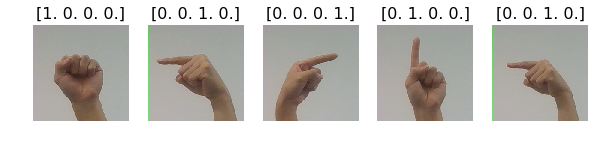

In [17]:
test_imgs,test_labels = next(test_batches) # show some test pictures
plots(test_imgs,titles=test_labels) 

In [18]:
predictions = model.predict_generator(test_batches,steps=2,verbose=0) # predict the class of each picture

In [19]:
predictions 
# print out the predicted label value, also in 'one-hot' format
# compare the prediction with the true label of pictures, you can see they are very close

array([[9.99164701e-01, 2.64759961e-04, 1.30995206e-04, 4.39500349e-04],
       [5.14196185e-03, 1.41466607e-03, 9.34375882e-01, 5.90675063e-02],
       [1.06736974e-04, 1.31072593e-03, 7.47247785e-03, 9.91110086e-01],
       [2.95240735e-03, 9.91797328e-01, 7.00506207e-05, 5.18034678e-03],
       [3.82491387e-03, 2.73064268e-03, 9.57364559e-01, 3.60799693e-02],
       [9.95067596e-01, 2.62630801e-03, 1.82883965e-03, 4.77276073e-04],
       [9.99394059e-01, 3.13084049e-04, 8.87894857e-05, 2.04054726e-04],
       [2.13976279e-02, 9.16719437e-01, 8.82189546e-04, 6.10007122e-02],
       [2.24510120e-04, 1.71474135e-03, 5.90574257e-02, 9.39003348e-01],
       [2.05149013e-03, 1.63471641e-03, 9.57944095e-01, 3.83697338e-02]],
      dtype=float32)

# Save your trained model

In [20]:
model.save('model.h5') # save the whole model you've trained just now as file 'model.h5', so you can use this model without training again